## Wilson's Algorithm for generating Uniform Spanning Tree

(Adapted the idea from Grimmett's Probability on Graphs)  
Last update: June 10, 2022

#### Uniform spanning tree:   

A spanning tree of a finite connected graph G is a connected subgraph of G containing every vertex and no cycles.  
(Ref: https://mathweb.ucsd.edu/~jschwein/LERW.pdf)

### Steps and desciptions

The first step is to import the necessary libraries.

In [1]:
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
import scipy as sp
import networkx as nx
import collections

Initiate the graph represented in sparse matrix form

In [2]:
G = nx.MultiDiGraph()
G.add_edge(0, 1)
G.add_edge(0, 3)
G.add_edge(0, 4)
G.add_edge(1, 0)
G.add_edge(3, 0)
G.add_edge(4, 0)
G.add_edge(1, 4)
G.add_edge(1, 5)
G.add_edge(1, 2)
G.add_edge(4, 1)
G.add_edge(5, 1)
G.add_edge(2, 1)
G.add_edge(2, 4)
G.add_edge(2, 5)
G.add_edge(2, 6)
G.add_edge(4, 2)
G.add_edge(5, 2)
G.add_edge(6, 2)
G.add_edge(3, 4)
G.add_edge(4, 3)
G.add_edge(4, 5)
G.add_edge(5, 4)
G.add_edge(5, 6)
G.add_edge(6, 5)

G2 = nx.MultiDiGraph()
G2.add_edge(0,1)
G2.add_edge(1,0)
G2.add_edge(0,2)
G2.add_edge(2,0)
G2.add_edge(1,2)
G2.add_edge(2,1)

G3 = nx.MultiDiGraph()
G3.add_edge(0,1)
G3.add_edge(1,0)
G3.add_edge(0,2)
G3.add_edge(2,0)
G3.add_edge(0,3)
G3.add_edge(3,0)
G3.add_edge(1,2)
G3.add_edge(2,1)
G3.add_edge(1,3)
G3.add_edge(3,1)
G3.add_edge(2,3)
G3.add_edge(3,2)

G4 = nx.MultiDiGraph()
G4.add_edge(0,1)
G4.add_edge(1,0)
G4.add_edge(0,2)
G4.add_edge(2,0)
G4.add_edge(0,3)
G4.add_edge(3,0)
G4.add_edge(0,4)
G4.add_edge(4,0)
G4.add_edge(1,2)
G4.add_edge(2,1)
G4.add_edge(1,3)
G4.add_edge(3,1)
G4.add_edge(1,4)
G4.add_edge(4,1)
G4.add_edge(2,3)
G4.add_edge(3,2)
G4.add_edge(2,4)
G4.add_edge(4,2)
G4.add_edge(3,4)
G4.add_edge(4,3)

A = nx.to_scipy_sparse_matrix(G2, nodelist=[0, 1, 2]) # 3 nodes
B = nx.to_scipy_sparse_matrix(G3, nodelist=[0, 1, 2, 3]) # 4 nodes
C = nx.to_scipy_sparse_matrix(G4, nodelist=[0, 1, 2, 3, 4]) # 5 nodes
D = nx.to_scipy_sparse_matrix(G, nodelist=[0, 1, 2, 3, 4, 5, 6]) # 7 nodes

`output_update` is a function which helps generate the output of the main function in a form of sparse matrix.

In [3]:
def output_update(pair, output):
    # Using pairs of nodes to generate output
    for i in pair:
        output[i[0]][i[1]] = 1
        output[i[1]][i[0]] = 1
    return output

Create the function called `sample_spanning_tree` that apply Wilson's algorithm to generate sample spanning tree from a connected graph (in sparse matrix form). The algorithm consists of 3 main steps.

1) Initiate the two random nodes from the input graph, and set up some necessary items to check conditions.     
2) Perform Loop-erased random walk (LERW) from the two randomly chosen nodes, obtain the initial path.
    - Based on the initial node, randomly choose the next node to walk to, and progressively update the path history
    - Let the last node be a new initial node and repeat the previous step until we reach the terminal node we randomly 
    chosen earlier
    - If the loop occurs during the walk, reset the path to where it starts the loop and walk again
    - Update the variables of components before performing the next step, and also return the output immediately if this is
    already a tree
3)  Continue performing LERW from unvisited nodes until it joins the initial path obtained from step 2) and all nodes are visited
    - Set up another necessary components for this step (remaining_node, pair_path, new_path, temp_path)
    - Generate new start node that is not in the initial path and perform LERW until it joins the initial path
        - If the next random node joins the initial path, update the path and set is_connected = True to identify that 
          there is at least one new path joins the initial path
        - Otherwise, check if the next random node creates the loop. If loop exists, reset the path and walk again. If not, 
          keep updating the path and keep walking
        - It has an exception when there is only one node left. This algorithm can be done by randomly
          selecting the next feasible node, so that it will definitely join the path
4) Return the outputs

In [4]:
def sample_spanning_tree(A):
    # Step 1: Function setup
    num_nodes = A.shape[0]
    mat_A = A.todense()
    universe_node_list = list(range(num_nodes))
    unused_node_list = list(range(num_nodes))
    visited_node = [False for node in range(num_nodes)]
    output_init = [[0 for col in range(num_nodes)] for row in range(num_nodes)]
    start_node = random.choice(unused_node_list)
    #print(start_node)
    unused_node_list.remove(start_node)
    terminal_node = random.choice(unused_node_list)
    unused_node_list.remove(terminal_node)
    path = []
    path.append(start_node)
    visited_node[start_node] = True
    is_already_tree = False
    
    # Step 2: Perform LERW and obtain the initial path
    while visited_node[terminal_node] == False:
        feasible_node = []
        for j in range(num_nodes):
            if mat_A[start_node, j] > 0: # This node pair is connected        
                feasible_node.append(j)
        next_node = random.choice(feasible_node)

        # Update a new initial node and add the edge to the graph
        visited_node[next_node] = True
        path.append(next_node)  
        start_node = next_node

        # If there's a loop, clear the loop (reset the path + work as if that path doesn't exist)
        if next_node in path:
            #output[start_node][next_node] = 0
            #output[next_node][start_node] = 0
            path = path[:path.index(next_node)+1]
            for i in path[path.index(next_node)+1:-1]: # Update selected node in the loop back to False
                visited_node[i] = False
                
    init_path = list.copy(path)
    # Update visited_node status after obtaining initial path           
    for i in universe_node_list:
        if i in init_path:
            visited_node[i] = True
        else:
            visited_node[i] = False

    # Update the output graph based on path result
    pair = []
    for i in range(len(init_path)-1):
        pair.append((init_path[i],init_path[i+1]))

    output = output_update(pair, output_init)
    
    # Step 3: Continue picking a random remaining node and walk to the initial path
    # until all nodes are visited.
    if set(path) == set(universe_node_list): # completely visited
        #print("1st case")
        is_already_tree = True
        return output, sp.sparse.csr_matrix(output), pair
    #print(pair)
    # Set up
    remaining_node = [i for i in range(len(visited_node)) if visited_node[i] == False]
    pair_path = []
    new_path = []
    temp_path = []
    is_connected = False
    
    while len(remaining_node) > 0 or is_connected == False:
        if len(temp_path) == 0: # need to generate new node
            new_start_node = random.choice(remaining_node)
            #print(new_start_node)
            temp_path.append(new_start_node)
        new_feasible_node = []
        for k in range(num_nodes):
            if A[new_start_node, k] > 0: # This node pair is connected        
                new_feasible_node.append(k)
        new_next_node = random.choice(new_feasible_node)
        #print(new_next_node)

        if new_next_node in path:
            if len(temp_path) > 1: # for the case when walking more than 1 node and reach the path later
                for i in range(len(temp_path)-1):
                    pair_path.append((temp_path[i],temp_path[i+1]))
            pair_path.append((new_start_node, new_next_node))
            path.extend(temp_path)
            #output[new_start_node][new_next_node] = 1
            #output[new_next_node][new_start_node] = 1
            remaining_node = [node for node in remaining_node if node not in temp_path]
            is_connected = True
            temp_path.clear()

        else:
            if new_next_node not in temp_path:
                if len(remaining_node) == 1: #this is the last node, and it should connect to node in path
                    new_start_node = new_next_node
                    new_feasible_node = []
                    for k in range(num_nodes):
                        if A[new_start_node, k] > 0: # This node pair is connected        
                            new_feasible_node.append(k)
                    new_next_node = random.choice(new_feasible_node)
                    temp_path = temp_path[:temp_path.index(new_next_node)+1]
                    path.extend(temp_path)
                    pair_path.append((new_start_node, new_next_node))
                    remaining_node.extend(loop)
                    break
                else:
                    temp_path.append(new_next_node)
                    #remaining_node.remove(new_next_node)
                    new_start_node = new_next_node
            else: # This is a loop
                loop = temp_path[temp_path.index(new_next_node)+1:-1]
                temp_path = temp_path[:temp_path.index(new_next_node)+1]
                remaining_node.extend(loop)
                new_start_node = new_next_node
                
    output = output_update(pair_path, output)  
    #print("2nd case")
    return output, sp.sparse.csr_matrix(output), init_path, pair, path, pair_path

In [5]:
# Sample output

x = sample_spanning_tree(A) # Spanning tree from 3 nodes graph
y = sample_spanning_tree(B) # Spanning tree from 4 nodes graph

In [6]:
y

([[0, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]],
 <4x4 sparse matrix of type '<class 'numpy.intc'>'
 	with 6 stored elements in Compressed Sparse Row format>,
 [2, 0],
 [(2, 0)],
 [2, 0, 1, 3],
 [(1, 0), (3, 0)])

### Outputs (in order)

- Dense matrix representing the graph of spanning tree
- Sparse matrix representing the graph of spanning tree
- The initial path from the random walk between two initial nodes
- The initial path in a form of paired node
- The path that further generated to join the initial path 
- The path that further generated to join the initial path in a form of paired node

### Spanning tree validation

This section aims to validate the function `sample_spanning_tree` that it works accurately. We create the function `spanning_tree_probability` that requires two arguments, a graph and number of times spanning tree generation. The procedures are as follows:

1) Transform the sparse matrix to tuple and count how many different spanning trees are generated  
2) Calculate the probability of each spanning tree and check the validity as, for example,

3 nodes graph: $3^{3-2} = 3$ possible spanning trees. Each different tree has probability of 1/3.  
4 nodes graph: $4^{4-2} = 4^2 = 16$ possible spanning trees. Each different tree has probability of 1/16.  
5 nodes graph: $5^{5-2} = 5^3 = 125$ possible spanning trees. Each different tree has probability of 1/125.  
7 nodes graph: $7^{7-2} = 7^5 = 16807$ possible spanning trees. Each different tree has probability of 1/16807.  

3) Return the output
    - number of counts for each types of spanning tree
    - probability list identified how likely they are generated
    - comparison between simulated probability and theoretical probability

In [7]:
def spanning_tree_probability(graph, ntimes):
    spanning_tree = [sample_spanning_tree(graph)[0] for j in range(ntimes)]
    
    # Firstly, transform the sparse matrix to immutable object (tuple), so it'll be hashable    
    for i in spanning_tree:
        for j in range(len(i)):
            i[j] = tuple(i[j])

    for i in range(len(spanning_tree)):
        spanning_tree[i] = tuple(spanning_tree[i]) 
    
    # Then, count how many different spanning trees are generated
    tree_count = {}
    for i in spanning_tree:
        tree_count[i] = tree_count.get(i,0) + 1
        
    # Finally, calculate the probability
    prob_list = []
    n_total = 0
    for i in tree_count:
        n_total += tree_count.get(i)

    for i in tree_count:
        prob_list.append(tree_count.get(i)/n_total)
    
    possible_tree = (graph.shape[0])**(graph.shape[0]-2)
    prob_diff = np.array(prob_list) - np.array(graph.shape[0]*(1/possible_tree) )
    return tree_count, prob_list, abs(prob_diff)

In [8]:
# Sample output

print(spanning_tree_probability(A, 10000)[1]) # generate 10000 spanning trees from 3-node graph
print(spanning_tree_probability(B, 20000)[1]) # generate 20000 spanning trees from 4-node graph
print(spanning_tree_probability(C, 30000)[1]) # generate 30000 spanning trees from 5-node graph

[0.333, 0.3302, 0.3368]
[0.0593, 0.0613, 0.06205, 0.06165, 0.06115, 0.0645, 0.06575, 0.0638, 0.0616, 0.06005, 0.06245, 0.06395, 0.06355, 0.06445, 0.0662, 0.05825]
[0.0079, 0.007533333333333334, 0.0078, 0.0077, 0.0081, 0.007566666666666667, 0.008566666666666667, 0.007633333333333333, 0.0078, 0.0075, 0.0081, 0.007866666666666666, 0.0083, 0.0084, 0.008166666666666666, 0.0078, 0.008366666666666666, 0.008766666666666667, 0.008066666666666666, 0.008666666666666666, 0.008666666666666666, 0.0071, 0.008, 0.008233333333333334, 0.0079, 0.009233333333333333, 0.007666666666666666, 0.007833333333333333, 0.007966666666666667, 0.008333333333333333, 0.008233333333333334, 0.0079, 0.007933333333333334, 0.007866666666666666, 0.008466666666666667, 0.008466666666666667, 0.007166666666666667, 0.0087, 0.008, 0.0077666666666666665, 0.0068, 0.008033333333333333, 0.0078, 0.008966666666666666, 0.0077666666666666665, 0.008033333333333333, 0.007533333333333334, 0.007833333333333333, 0.0074, 0.008233333333333334, 0.

### Degree computation and CDF plots

Next step is to compute the degrees of all vertices of a tree, and to consider CDF of the degrees.

In [9]:
def degree_cdf(g, n):
    '''To calculate the degree of all vertices of a tree, take a look at the CDF of the degrees, aggregating over all
    randomly-generated spanning trees'''
    cdf_mat = []
    
    # Generate n spanning tree from the original graph, g.
    for _ in range(n):
        sample_tree = sample_spanning_tree(g)
        
        # For each tree, compute degrees and sort them.
        degrees = []
        for i in sample_tree[0]:
            degrees.append(sum(i))
        degrees_seq = sorted(degrees)
        deg_counter = collections.Counter(degrees_seq) # Count the number of times for each degree
        
        # Look at how PMF and CDF of the degrees looks, collect all degree CDF from individual spanning tree.
        pmf_dict = {}

        for i in deg_counter:
            pmf_dict[i] = round(deg_counter.get(i)/len(degrees_seq), 3)
        pmf = list(pmf_dict.values())
        cdf = np.cumsum(pmf)
        cdf_mat.append(cdf)
        
    return cdf_mat

### Sample output

In [10]:
# First, we originate complete graph g
g = nx.to_scipy_sparse_matrix(nx.complete_graph(21))

# Then, we generate a lot of spanning trees and compute degrees
degree_cdf(g,100)

[array([0.476, 0.762, 0.905, 0.953, 1.001]),
 array([0.333, 0.809, 0.952, 1.   ]),
 array([0.429, 0.715, 0.953, 1.001]),
 array([0.381, 0.857, 0.952, 1.   ]),
 array([0.333, 0.809, 0.952, 1.   ]),
 array([0.476, 0.762, 0.952, 1.   ]),
 array([0.429, 0.715, 0.953, 1.001]),
 array([0.429, 0.715, 0.953, 1.001]),
 array([0.429, 0.81 , 0.905, 0.953, 1.001]),
 array([0.476, 0.762, 0.952, 1.   ]),
 array([0.381, 0.762, 0.952, 1.   ]),
 array([0.333, 0.809, 0.952, 1.   ]),
 array([0.429, 0.762, 0.905, 1.   ]),
 array([0.524, 0.762, 0.905, 1.   ]),
 array([0.238, 0.857, 1.   ]),
 array([0.429, 0.715, 0.953, 1.001]),
 array([0.429, 0.762, 0.952, 1.   ]),
 array([0.381, 0.762, 0.952, 1.   ]),
 array([0.381, 0.81 , 0.953, 1.001]),
 array([0.429, 0.81 , 0.905, 0.953, 1.001]),
 array([0.381, 0.81 , 0.953, 1.001]),
 array([0.381, 0.762, 0.952, 1.   ]),
 array([0.381, 0.762, 0.952, 1.   ]),
 array([0.524, 0.762, 0.905, 1.   ]),
 array([0.429, 0.762, 0.905, 1.   ]),
 array([0.333, 0.762, 1.   ]),
 arra

In [11]:
# Next, we find the average of the CDF of each degree
## Collect all CDF with indices
res = []
for i in degree_cdf(g,100):
    for j in range(len(i)):
        res.append((j+1, i[j]))

## Calculate the average of each CDF with distinct index (key)        
avg_res = {}
for key, val in res:
    avg_res.setdefault(key, []).append(val) # If there is a key, do nothing. If not, append new value into blank list
    
for i in avg_res:
    avg_res[i] = np.average(avg_res[i])
    # Modify some value
    if avg_res[i] > 1:
        avg_res[i] = 1    

### Output plots with average line plots

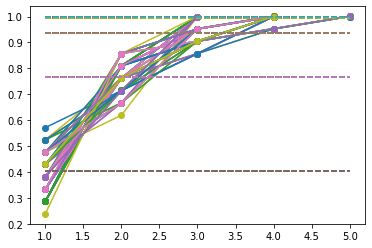

In [12]:
fig, ax = plt.subplots()

for i in degree_cdf(g,100):
    ax.plot(np.arange(len(i))+1, i, marker="o")
    for j in range(len(list(avg_res.values()))):
        y_mean = [list(avg_res.values())[j]]*len(list(avg_res.values()))
        ax.plot(list(avg_res), y_mean, linestyle="--")